<a href="https://colab.research.google.com/github/Da-Seungheon/RFM_Data_Analysis/blob/main/03_%EB%93%B1%EA%B8%89%EB%A7%A4%EA%B8%B0%EA%B8%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recency, Frequency, Monetary 등급 매기기

In [4]:
!pip install koreanize_matplotlib

%config lineBackendin.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib


data_path = '/content/drive/MyDrive/04_코드잇csv/customer_data.csv'
df = pd.read_csv(data_path, sep='\t')
df.tail()

,ID,signup_ym,birth_year,annual_income,marital_status,children,recency,amount_alcohol,amount_fruit,amount_meat,...,num_purchase_web,num_purchase_store,num_purchase_discount,promotion_1,promotion_2,promotion_3,promotion_4,promotion_5,promotion_6,revenue
2235,10870,2021-09,1975,79589900.0,배우자 있음,1,46,921700,55900,236600,...,9,4,2,0,0,0,0,0,0,11
2236,4001,2022-09,1954,83218200.0,배우자 있음,3,56,527800,0,39000,...,8,5,7,1,0,0,0,0,0,11
2237,7270,2022-04,1989,74075300.0,이혼,0,91,1180400,62400,282100,...,2,13,1,0,0,0,1,0,0,11
2238,8235,2022-04,1964,90018500.0,배우자 있음,1,8,556400,39000,278200,...,6,10,2,0,0,0,0,0,0,11
2239,9405,2021-01,1962,68729700.0,배우자 있음,2,40,109200,3900,79300,...,3,4,3,0,0,0,0,0,1,11


- 우선 Recency, Frequency, Monetary 각 항목의 등급 개수를 지정해야 합니다. 편의상 3개로 하여 1등급, 2등급, 3등급으로 나누겠습니다. 이때 등급의 숫자는 클수록 더 긍정적인 것으로 가정할게요. 즉, Recency 등급의 숫자는 클수록 더 최근에 구매했다는 뜻이고, Frequency 등급의 숫자는 클수록 더 자주 구매했다는 뜻이며, Monetary 등급의 숫자는 클수록 돈을 더 많이 썼다는 의미가 됩니다. 등급 개수는 앞으로 자주 사용할 예정이라서 미리 num_grades라는 변수에 담아 놓겠습니다.

In [17]:
#amount 컬럼은 각각의 품목별 구매 금액을 나타내고 있으니 다 더한 값을 새로운 변수에 저장하자
data_amount_total = (
    df['amount_alcohol']
    + df['amount_fruit']
    + df['amount_meat']
    + df['amount_fish']
    + df['amount_snack']
    + df['amount_general']
)

# 컬럼 이름 변경하자
df['amount_total'] = data_amount_total

In [18]:
num_grades = 3

grade_labels = list(range(1, num_grades + 1))
grade_labels

[1, 2, 3]

- 먼저 Recency 등급부터 매겨 볼게요. customer_df에서는 recency 컬럼을 보면 되겠군요. ***편의상 각 등급마다 고객의 수를 최대한 균등하게 나누겠습니다***. 이런 방식에 사용되는 함수는 qcut()으로, x 파라미터에 넣어 준 데이터를 q 파라미터에 넣어 준 값만큼 등분해 줍니다. 이 함수에서는 labels 파라미터를 통해 각 등급을 어떻게 표시할지 지정할 수 있는데요. recency 컬럼 값이 작은 고객일수록 최근에 구매를 했다는 뜻이니 Recency 등급을 더 높게 부여해야 합니다. 즉, qcut()을 통해 고객을 세 그룹으로 나누었을 때 앞 그룹이 3등급, 중간 그룹이 2등급, 뒷 그룹이 1등급이 되는 거죠. 따라서 labels 파라미터에 grade_labels를 역순으로 넣어 줘야 해요. 역순으로 뒤집힌 리스트는 원본 리스트를 [::-1]처럼 슬라이싱 해 주면 얻을 수 있습니다. 그럼 qcut() 함수의 x에 recency 컬럼 데이터를 전달하고, q에는 num_grades 변수를 전달하고, labels에는 grade_labels[::-1]을 전달해 볼게요.

In [19]:
recency_grade = pd.qcut(x=df['recency'], q=num_grades, labels=grade_labels[::-1])
df['recency_grade'] = recency_grade

In [20]:
# 1등급부터 3등급까지 정확히 똑같이 분배된 건 아니지만 비슷한 비율로 나뉘었음
df['recency_grade'].value_counts()

,count
recency_grade,
3,763
1,746
2,731


- 그럼 Recency 등급에 따라 매출 기여도가 어떻게 다른지 시각화할게요
 각 등급의 매출 기여도는 전체 매출 대비 해당 등급의 매출 비율로 구할 수 있습니다. 그렇다면 먼저 recency_grade 컬럼 기준으로 groupby 한 다음 sum() 함수를 써서 등급별 매출 합계를 구할게요. sum() 함수를 사용할 때에는 숫자 값들만 합을 구할 수 있게 numeric_only 값을 True로 설정하겠습니다. 마지막으로 reset_index() 함수까지 사용해 주면 깔끔하게 recency_grade도 컬럼으로 만들 수 있어요. 이 groupby 결과는 groupby_recency_grade 변수에 담겠습니다. 1등급에서 3등급으로 갈수록 recency 컬럼의 값이 줄어드는 걸 보면 등급이 제대로 매겨진 것 같습니다

In [21]:
recency_group = df.groupby('recency_grade').sum(numeric_only=True).reset_index()
recency_group

<ipython-input-21-dc42e5169e60>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  recency_group = df.groupby('recency_grade').sum(numeric_only=True).reset_index()


,recency_grade,ID,birth_year,annual_income,children,recency,amount_alcohol,amount_fruit,amount_meat,amount_fish,...,num_purchase_store,num_purchase_discount,promotion_1,promotion_2,promotion_3,promotion_4,promotion_5,promotion_6,revenue,amount_total
0,3,4406025,1508695,5.216153e+10,690,12198,294985600,26835900,162347900,37732500,...,4416,1733,54,12,67,55,60,179,8393,590946200
1,2,4056195,1444646,4.850360e+10,733,36208,295907300,23933000,154771500,35363900,...,4263,1785,47,8,47,53,49,95,8041,577081700
2,1,4064218,1474704,4.984876e+10,706,61599,294167900,25823200,169039000,36177700,...,4291,1690,43,10,49,59,54,60,8206,596056500


- groupby_recency_grade의 amount_total 컬럼에 대해 파이 차트를 그려 주면 등급별로 매출 기여도가 어떻게 다른지 한눈에 볼 수 있습니다. plot() 함수에서 kind를 'pie'로 설정해 주면 되겠죠.

<Axes: ylabel='amount_total'>

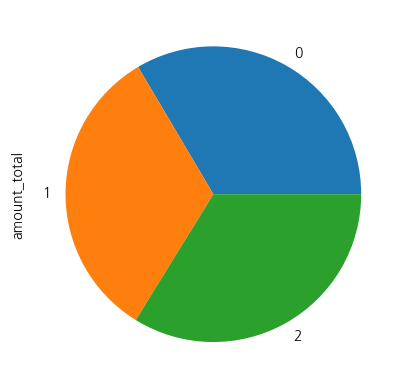

In [22]:
 recency_group['amount_total'].plot(kind='pie')

- 이렇게만 그려서는 정보를 파악하기가 쉽지 않네요. 그래프를 조금 더 알아보기 좋게 파라미터들을 추가로 설정해 봅시다. autopct 파라미터에 '%.1f%%'를 넣어 주면 파이 차트 내 각 영역의 비중 퍼센트를 소수 첫 번째 자리까지 표시할 수 있습니다. labels 파라미터로는 각 영역에 이름을 붙일 수 있어서, 등급을 나타내는 숫자 뒤에 ‘등급’을 붙인 문자열 리스트를 list comprehension으로 만들어 넣어 줄게요. 앞서 qcut() 함수를 통해 구간화할 때 grade_labels를 역순으로 뒤집어서 전달했으니, 이번에도 영역 이름을 3등급부터 1등급 순으로 넣어 줘야 합니다. title에는 그래프 제목을 적당히 전달해 줄게요. ylabel은 따로 지정하지 않으면 컬럼 이름이 좌측에 표시되는데 이를 막기 위해 빈 문자열을 넣어 주겠습니다. 이렇게 다시 그려 보면 전보다 그래프를 파악하기가 더 쉬워지죠. 결과를 보니 Recency 등급에 따라서는 매출 기여도의 차이가 거의 없습니다.

<Axes: title={'center': 'Recency 등급별 매출 기여도'}>

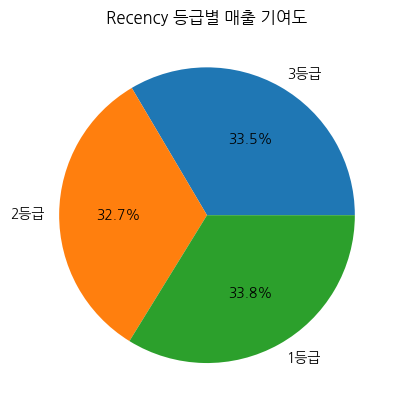

In [23]:
recency_group['amount_total'].plot(
    kind='pie',
    autopct='%.1f%%',  # 파이 차트 내 각 영역의 비중 퍼센트를 첫번쨰 자리까지 표시
    labels=[f'{x}등급' for x in grade_labels[::-1]],
    title='Recency 등급별 매출 기여도',
    ylabel='',
)

- 이번에는 Frequency 등급을 매겨 볼게요. Frequency와 관련된 컬럼은 num_purchase_total이죠. Recency와 마찬가지로 qcut() 함수를 이용해 등급을 나누겠습니다. 주의할 점이 하나 있는데요. num_purchase_total 컬럼은 값이 클수록 더 자주 구매를 했다는 뜻이므로 더 높은 등급이 매겨져야 합니다. 그래서 이번에는 labels에 grade_labels 리스트를 그대로 전달해 줘야 해요. qcut() 함수 결과는 customer_df에 frequency_grade라는 이름의 컬럼으로 추가하겠습니다.

In [25]:
num_purchase_total = (
    df['num_purchase_web']
    + df['num_purchase_store']
    + df['num_purchase_discount']
)

index_num_purchase_discount = df.columns.get_loc('num_purchase_discount')
df.insert(
    loc=index_num_purchase_discount + 1,
    column='num_purchase_total',
    value=num_purchase_total,
)
df.head()

,ID,signup_ym,birth_year,annual_income,marital_status,children,recency,amount_alcohol,amount_fruit,amount_meat,...,num_purchase_total,promotion_1,promotion_2,promotion_3,promotion_4,promotion_5,promotion_6,revenue,recency_grade,amount_total
0,5524,2020-12,1965,75579400.0,미혼,0,58,825500,114400,709800,...,15,0,0,0,0,0,1,11,2,2102100
1,2174,2022-06,1962,60247200.0,미혼,2,38,14300,1300,7800,...,5,0,0,0,0,0,0,11,2,35100
2,4141,2021-11,1973,93096900.0,배우자 있음,0,26,553800,63700,165100,...,19,0,0,0,0,0,0,11,3,1008800
3,6182,2022-05,1992,34639800.0,배우자 있음,1,26,14300,5200,26000,...,8,0,0,0,0,0,0,11,3,68900
4,5324,2022-04,1989,75780900.0,배우자 있음,1,94,224900,55900,153400,...,16,0,0,0,0,0,0,11,1,548600


In [26]:
df['frequency_grade'] = pd.qcut(
    x=df['num_purchase_total'], q=num_grades, labels=grade_labels
)

In [27]:
df.head(1)

,ID,signup_ym,birth_year,annual_income,marital_status,children,recency,amount_alcohol,amount_fruit,amount_meat,...,promotion_1,promotion_2,promotion_3,promotion_4,promotion_5,promotion_6,revenue,recency_grade,amount_total,frequency_grade
0,5524,2020-12,1965,75579400.0,미혼,0,58,825500,114400,709800,...,0,0,0,0,0,1,11,2,2102100,2


In [28]:
df['frequency_grade'].value_counts()


,count
frequency_grade,
1,871
2,687
3,682


<ipython-input-31-054566532743>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_frequency_grade = df.groupby('frequency_grade').sum(numeric_only=True).reset_index()


<Axes: title={'center': 'Frequency 등급별 매출 기여도'}>

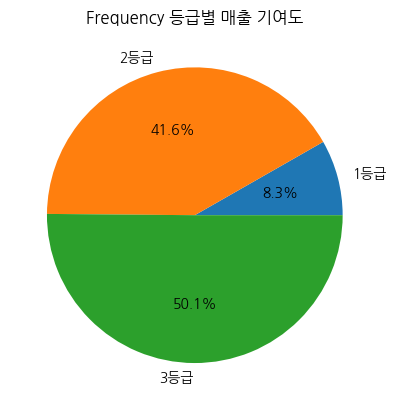

In [31]:
group_frequency_grade = df.groupby('frequency_grade').sum(numeric_only=True).reset_index()
group_frequency_grade['amount_total'].plot(
    kind='pie',
    autopct='%.1f%%',
    labels = [f'{x}등급' for x in grade_labels],
    title='Frequency 등급별 매출 기여도',
    ylabel='',
)

- Frequency도 등급별 매출 기여도를 파이 차트로 그려 봅시다. Recency 때와 비슷하게 frequency_grade 컬럼에 대해 groupby 한 뒤 sum() 함수를 사용할게요. 이 groupby 결과의 amount_total 컬럼에 대해 파이 차트를 그리면 되겠습니다. 시각화한 걸 보니 매출 기여도는 3등급, 2등급, 1등급 순으로 높군요. 3등급과 2등급의 매출 기여도 차이는 그리 크지 않고, 둘에 비해 1등급의 매출 기여도가 상당히 낮습니다. 1등급 고객의 수가 더 많은데도 이런 결과가 나오다니 흥미롭네요.

- 마지막으로 Monetary 등급을 구할 차례입니다. 이번에는 amount_total 컬럼을 구간화하면 되겠죠. Monetary는 구매 금액을 뜻하므로 Frequency와 마찬가지로 숫자가 클수록 더 높은 등급이 매겨져야 할 거예요. qcut() 함수로 등급을 나눈 뒤 customer_df에 monetary_grade라는 컬럼으로 추가하겠습니다.

In [35]:
df['monetary_grade'] = pd.qcut(
    x=df['amount_total'], q=num_grades, labels=grade_labels
)

In [37]:
df['monetary_grade'].value_counts()

,count
monetary_grade,
1,748
3,747
2,745


<ipython-input-40-657194afda1e>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groupby_monetary_grade = df.groupby('monetary_grade').sum(numeric_only=True).reset_index()


<Axes: title={'center': 'Monetary 등급별 매출 기여도'}>

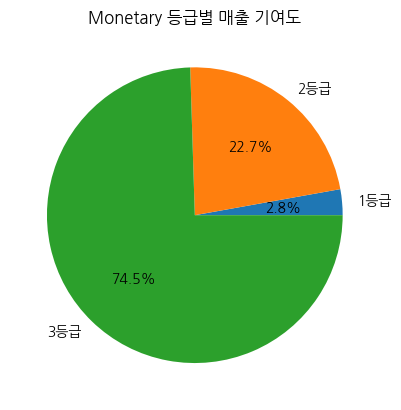

In [40]:
groupby_monetary_grade = df.groupby('monetary_grade').sum(numeric_only=True).reset_index()
groupby_monetary_grade['amount_total'].plot(
    kind='pie',
    autopct='%.1f%%',
    labels = [f'{x}등급' for x in grade_labels],
    title = 'Monetary 등급별 매출 기여도',
    ylabel=''
)

- 이제 Monetary 등급에 따라 매출 기여도가 어떻게 다른지 파이 차트로 그려 볼게요. 결과를 보면 3등급의 매출 기여도가 매우 높고 1등급의 매출 기여도는 아주 낮게 나오네요. 아무래도 Monetary 등급은 돈을 얼마나 썼는지와 직접적으로 관련되기 때문에 그만큼 매출 기여도가 명확히 구분되는 것 같습니다.

# 가중합을 이용해 RFM 고객 세그먼트 분류하기

- Recency, Frequency, Monetary 각 항목의 등급을 모두 매겼으니 이제 이를 활용해 고객 지표를 구하고 고객 세그먼트 분류까지 해 볼게요. 먼저 Recency, Frequency, Monetary 등급 각각에 가중치를 곱한 뒤 더하면 고객 지표가 계산됩니다. 이 고객 지표를 몇 가지 등급으로 나누면 최종 고객 세그먼트를 구할 수 있죠. 그럼 RFM 고객 세그먼트의 등급 개수도 3개로 두고 진행해 보겠습니다

- 일단 세 항목에 동일하게 가중치를 줄 때 고객 세그먼트가 어떻게 나오는지 확인해 볼까요? 세 항목에 대한 가중치에는 조건이 있었죠. 각각 0보다 크거나 같아야 하고 모두 더했을 때 1이 되어야 합니다. 가중치 조건을 고려했을 때 각 항목에 1/3씩 가중치를 부여하면 되겠군요. 가중치는 weight라는 이름의 딕셔너리 변수를 이용해 관리하겠습니다.

In [41]:
weight = {}
weight['recency'] = 1 / 3
weight['frequency'] = 1 / 3
weight['monetary'] = 1 / 3


- 여기서 주의할 점이 하나 있는데요. customer_df에 Recency, Frequency, Monetary 각 등급이 숫자 1, 2, 3으로 표시되어 있지만, 엄밀히 말하면 등급 값은 모두 숫자형 데이터가 아니라 범주형 데이터인 상태입니다. 가중치를 적용하는 연산을 하려면 astype() 함수를 이용해 숫자형 데이터로 바꿔 줘야 해요. 어차피 등급 값은 1, 2, 3 뿐이니 정수형으로 바꿔도 무방하겠습니다. 그럼 항목에 맞게 가중치와 등급을 곱한 뒤 더해 줍시다. 이렇게 구한 고객 지표는 customer_df에 rfm_score 컬럼으로 추가할게요.

In [42]:
df['rfm_score'] = (
    weight['recency'] * df['recency_grade'].astype('int')
    + weight['frequency'] * df['frequency_grade'].astype('int')
    + weight['monetary'] * df['monetary_grade'].astype('int')
)
df['rfm_score']

,rfm_score
0,2.333333
1,1.333333
2,2.666667
3,1.666667
4,2.000000
...,...
2235,2.333333
2236,2.333333
2237,2.333333
2238,3.000000


- 이제 고객 지표를 세 등급으로 구간화하면 고객 세그먼트 분류를 마칠 수 있습니다. 고객 지표는 그 범위가 1 이상 3 이하일 수밖에 없는데요. Recency, Frequency, Monetary 모두 등급 값이 1, 2, 3으로 한정되어 있고, 각 가중치는 모두 더해서 1이라는 제약 조건까지 있기 때문입니다. 최솟값과 최댓값이 확실하게 정해져 있으니 등급마다 고객 수를 균등하게 분배하기보다는, 최솟값과 최댓값을 고려하여 동일한 크기의 구간으로 고객을 분류해 볼게요. 아래와 같이 구간을 정하면 세 구간의 크기가 모두 2/3가 되겠죠? 물론 구간 경계에서 이상과 초과, 이하와 미만의 차이 때문에 2등급 고객의 수가 더 많아질 가능성이 있긴 합니다.

In [44]:
def rfm_segment_bins(x):
    if x < 5 / 3:
        return 1
    elif x <= 7 / 3:
        return 2
    else:
        return 3


df['rfm_segment'] = df['rfm_score'].apply(rfm_segment_bins)
df['rfm_segment'].value_counts()

,count
rfm_segment,
1,945
2,822
3,473


<Axes: title={'center': 'RFM 고객 세그먼트별 매출 기여도'}>

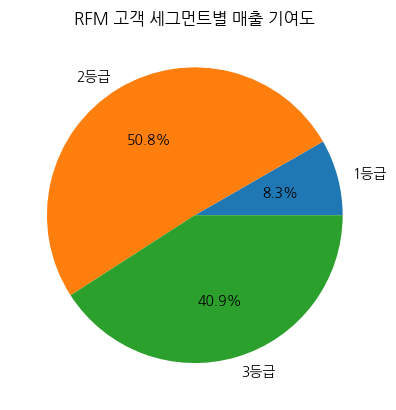

In [45]:
groupby_rfm_segment = df.groupby('rfm_segment').sum(numeric_only=True).reset_index()
groupby_rfm_segment['amount_total'].plot(
    kind='pie',
    autopct='%.1f%%',
    labels=[f'{x}등급' for x in grade_labels],
    title='RFM 고객 세그먼트별 매출 기여도',
    ylabel='',
)


- 그럼 고객 세그먼트별로 매출 기여도가 어떻게 다른지 살펴봅시다. 이번에는 rfm_segment 컬럼을 기준으로 groupby 해 준 뒤 파이 차트를 그려야겠군요. 결과를 보면 1등급 세그먼트 고객은 확실히 매출에 적게 기여하고 있습니다만, 2등급과 3등급의 매출 기여도 차이가 그리 크지 않습니다. 매출 기여도가 더 확연히 높은 세그먼트가 있어야 그 고객들에게 집중할 수 있을 텐데 말이죠. 가중치를 변경하여 다시 고객 지표를 계산하고 고객 세그먼트까지 나누어 봐야겠습니다.

- 앞선 분석에서 Recency 등급은 등급별로 매출 기여도 차이가 거의 없었는데요. 그렇다면 Recency 가중치를 줄이고 다른 항목의 가중치를 높였을 때, 고객 세그먼트별 매출 기여도의 차이가 더 뚜렷해질 것이라고 추측할 수 있습니다. Recency 가중치를 0.2로 줄이고 다른 두 가중치는 동등하게 0.4씩 설정한 뒤 같은 과정을 반복해 봅시다.

In [46]:
# 가중치 재설정
weight['recency'] = 0.2
weight['frequency'] = 0.4
weight['monetary'] = 0.4

# 가중합 계산
df['rfm_score'] = (
    weight['recency'] * df['recency_grade'].astype('int')
    + weight['frequency'] * df['frequency_grade'].astype('int')
    + weight['monetary'] * df['monetary_grade'].astype('int')
)

# RFM 고객 지표 구간화
df['rfm_segment'] = df['rfm_score'].apply(rfm_segment_bins)


In [49]:
df['rfm_segment'].value_counts()

,count
rfm_segment,
1,816
3,799
2,625


<Axes: title={'center': 'RFM 고객 세그먼트별 매출 기여도'}>

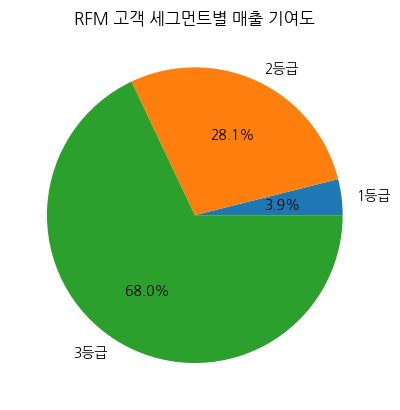

In [50]:
groupby_rfm_segment = df.groupby('rfm_segment').sum(numeric_only=True).reset_index()
groupby_rfm_segment['amount_total'].plot(
    kind='pie',
    autopct='%.1f%%',
    labels=[f'{x}등급' for x in grade_labels],
    title='RFM 고객 세그먼트별 매출 기여도',
    ylabel='',
)


- 세그먼트별 매출 기여도를 파이 차트로 그려 보니 3등급 세그먼트의 매출 기여도가 70%에 육박합니다. 2등급 세그먼트는 27% 정도, 1등급 세그먼트는 4%로, 3등급 세그먼트의 매출 기여도가 확연히 높군요. 매출 기여도가 높은 3등급 세그먼트를 핵심 고객 그룹으로 생각하고 집중적으로 관리해 주면 앞으로도 매출에 도움이 되겠죠?

In [51]:
# 먼저 고객의 출생년도를 조금 더 직관적인 값이 나이로 변경해보자
# 2023년 1월이 기준 시점이므로 2023년에서 birth_year 컬럼을 뺀 나이를 구하고 기존 컬럼에 저장하자
df['birth_year'] = 2023 - df['birth_year']

# 컬럼이름을 age로 변경하자
df = df.rename(columns={'birth_year' : 'age'})
df.head(1)

,ID,signup_ym,age,annual_income,marital_status,children,recency,amount_alcohol,amount_fruit,amount_meat,...,promotion_4,promotion_5,promotion_6,revenue,recency_grade,amount_total,frequency_grade,monetary_grade,rfm_score,rfm_segment
0,5524,2020-12,58,75579400.0,미혼,0,58,825500,114400,709800,...,0,0,1,11,2,2102100,2,3,2.4,3


In [55]:
#cut() 함수를 호출할 때에는 x 파라미터에 구간화할 데이터를,
#bins 파라미터에 구간을 나타내는 리스트를,
#labels 파라미터에 구간 이름을 나타내는 리스트를 전달합니다.
#마지막으로 right 파라미터가 있는데요. 구간의 오른쪽 값을 포함할지 안 할지를 의미합니다.
#연령대 구간을 나눌 때 왼쪽 값 '이상', 오른쪽 값 '미만'으로 경계를 정했으니 오른쪽 값이 포함되면 안 되겠죠.
#즉 False를 전달해 주면 됩니다.
age_bins = list(range(10, 81, 10))

age_labels = [f'{x}대' for x in age_bins[:-1] ]

age_group = pd.cut(x=df['age'], bins=age_bins, labels=age_labels, right=False)

df.insert(
    loc=df.columns.get_loc('age') + 1,
    column='age_group',
    value=age_group,
)

age_group_replace_dict = {
    '10대': '20대 이하',
    '20대': '20대 이하',
    '60대': '60대 이상',
    '70대': '60대 이상',
}
df['age_group'] = df['age_group'].replace(age_group_replace_dict)


ValueError: cannot insert age_group, already exists

In [56]:
df.head(1)

,ID,signup_ym,age,age_group,annual_income,marital_status,children,recency,amount_alcohol,amount_fruit,...,promotion_4,promotion_5,promotion_6,revenue,recency_grade,amount_total,frequency_grade,monetary_grade,rfm_score,rfm_segment
0,5524,2020-12,58,50대,75579400.0,미혼,0,58,825500,114400,...,0,0,1,11,2,2102100,2,3,2.4,3


- 모든 데이터가 잘 입력된 것을 알 수 있습니다